In [1]:
# sys, file and nav packages:
import datetime as dt
import json
import functools
import time

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display
from myst_nb import glue

import time

start_date = '2020-03-01'
end_date ='2021-05-31'

a_qty = 20

a_fail_rate = .5

use_fail = False

unit_label = 'p/100m'

# survey data:
dfx= pd.read_csv('resources/checked_sdata_eos_2020_21.csv')

dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of to codes
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description

# code material map
code_m_map = dfCodes.material



# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]

In [2]:

pdtype = pd.core.frame.DataFrame
pstype = pd.core.series.Series

new_label_keys = {
    1:"industrial",
    2:"buildings",
    3:"buildings",
    4:"buildings",
    5:"buildings",
    6:"transport",
    7:"transport",
    8:"transport",
    9:"buildings",
    10:"recreation",
    11:"agriculture",
    12:"agriculture",
    13:"agriculture",
    14:"agriculture",
    15:"agriculture",
    16:"agriculture",
    17:"woods",
    18:"agriculture",
    19:"woods",
    20:"woods",
    21:"woods",
    22:"woods",
    23:"water",
    24:"water",
    25:"unproductive",
    26:"unproductive",
    27:"unproductive"
}


def combineLandUseFeatures(buffer_data: pdtype = None, a_col: str = "AS18_27", new_col: str = "label",
                           new_label_keys: dict = new_label_keys) -> pdtype:
    """Assigns labels to landuse values according to <label_keys_new>. The new labels,
    when aggregated, create groups of landuse values that are similar. For exmaple,
    all the different types of buildings are labeled "buildings"
    
    Args:
        buffer_data: The land use values at a given radius
        a_col: The original column name that holds the labels for the land use values
        new_col: The new name of the column with the new labels
    
    Returns:
        The data frame with the new column and the new labels    
    """    
    
    buffer_data.rename(columns={"slug":"location", a_col:new_col}, inplace=True)
    buffer_data[new_col] = buffer_data[new_col].apply(lambda x : new_label_keys[x])
    
    return buffer_data

def adjustLandUse(buffer_data: pdtype = None, exclude_these: list = [], locations: list = []) -> pdtype:
    """The surface area of the water feature is removed from landuse calcluation. This
    can be bypassed. However, the study considers the surface area of the water as a fixed
    feature that exchanges with the different landuse features (which are not fixed).
    
    Args:
        buffer_data: The land use values at a given radius
        exclude_these: The labels to be excluded from the land use total
        locations: The locations of interest with buffer data
        
    Returns:
        The dataframe with the locations in locations and without the excluded labels      
    """
    data = buffer_data[~buffer_data.label.isin(exclude_these)]
    data = data[data.location.isin(locations)]
    
    return data

def addRoadLengthToBuffer(buffer_data: pdtype = None, location: str = None, 
                          road_lengths: pstype = None, scale: float = 1000.0):
    """Adds the length of road network to the % land use values.
    """
    
    road_length = road_lengths.loc[location]
    if scale != 1:
        road_length = round(road_length/scale, 1)
    
    buffer_data["roads"] = road_length
    
    return buffer_data

def addIntersectsToBuffer(buffer_data: pdtype = None, location: str = None, 
                          intersects: pstype = None, scale: float = 100.0):
    
    """Adds the number of river intersections to the buffer.
    
    The river intersections are the points where rivers join the body of water of interest
    """
    
    n_intersects = intersects.loc[location]
        
    buffer_data["intersects"] = n_intersects
    
    return buffer_data

def calculatePercentLandUse(buffer_data: pdtype = None, location: str = None, label: str = "label",
                           add_intersects_roads: bool = True,  road_lengths: pstype = None, intersects: pstype = None) -> pd.Series:
    """Figures the % of total of each landuse feature for one location.
    
    Args:
        buffer_data: The land use values at a given radius
        location: The survey location of interest
    
    Returns:
        A pandas series of the % of total for each landuse feature in the index
    """
    
    try:
        # try to reitrieve the land use data for a location
        location_data = buffer_data[buffer_data.location == location][label].value_counts()
    except ValueError:
        print("The location data could not retrieved")
        raise
    
    # the sum of all land use features in the radius
    total = location_data.sum()
    # the amount of the area attributed to water (lakes and rivers)
    water = location_data.loc["water"]   
    # divide the land_use values by the total minus the amount attributed to water
    results = location_data/(total-water)
    # name the series
    results.name = location
    # the intersects and road-lengths are calculated seprately
    # if add_intersects and roads is true, attach them to the
    # the land use values
    if add_intersects_roads:
        results = addIntersectsToBuffer(buffer_data=results, location=location, intersects=intersects)
        results = addRoadLengthToBuffer(buffer_data=results, location=location, road_lengths=road_lengths)
    
    return results

class BufferData:
    a_col="AS18_27"
    new_col = "label"
    exclude_these = []
    label_keys = new_label_keys
    beach_data = dfBeaches
    
    
    def __init__(self, file_name: str = None, locations: list = []):
        self.buffer = pd.read_csv(file_name)
        self.buffer_data = combineLandUseFeatures(buffer_data=self.buffer, a_col=self.a_col, new_col=self.new_col)
        self.adjusted_buffer = adjustLandUse(buffer_data=self.buffer_data, exclude_these=self.exclude_these, locations=locations)
        self.pctLandUse = None
        self.locations = locations
        
    def percentLandUse(self):
        
        if isinstance(self.pctLandUse, pdtype):
            return self.pctLandUse
        
        if isinstance(self.adjusted_buffer, pdtype):
            results = []
            road_lengths = self.beach_data.streets
            intersects = self.beach_data.intersects
            for location in self.locations:
                result = calculatePercentLandUse(buffer_data=self.adjusted_buffer, location=location, road_lengths=road_lengths, intersects=intersects)
                results.append(result)
        else:
            raise TypeError
            
        self.pctLandUse = pd.concat(results, axis=1)
        
        return self.pctLandUse

In [3]:
def timer(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print("Finished {} in {} secs".format(repr(func.__name__), round(run_time, 3)))
        return value

    return wrapper

def assignLanduseValue(sample: pstype=None, land_use: str=None) -> float:
    # returns the requested value of land use from the sample
    # if the requested landuse value is not present in the buffer
    # zero is returned
    try:
        result = sample.loc[land_use]
    except KeyError:
        result = 0
    
    return result

def cleanSurveyResults(data):
    # performs data cleaning operations on the
    # default data
    
    data['loc_date'] = list(zip(data.location, data["date"]))
    data['date'] = pd.to_datetime(data["date"])
    
    # get rid of microplastics
    mcr = data[data.groupname == "micro plastics (< 5mm)"].code.unique()
    
    # replace the bad code
    data.code = data.code.replace('G207', 'G208')
    data = data[~data.code.isin(mcr)]
    
    # walensee has no landuse values
    data = data[data.water_name_slug != 'walensee']   
    
    return data

class SurveyResults:
    """Creates a dataframe from a valid filename. Assigns the column names and defines a list of
    codes and locations that can be used in the CodeData class.
    """
    
    file_name = 'resources/checked_sdata_eos_2020_21.csv'
    columns_to_keep=[
        'loc_date',
        'location', 
        'river_bassin',
        'water_name_slug',
        'city',
        'w_t', 
        'intersects', 
        'code', 
        'pcs_m',
        'quantity'
    ]
        
    def __init__(self, data: str = file_name, clean_data: bool = True, columns: list = columns_to_keep, w_t: str = None):
        self.dfx = pd.read_csv(data)
        self.df_results = None
        self.locations = None
        self.valid_codes = None
        self.clean_data = clean_data
        self.columns = columns
        self.w_t = w_t
        
    def validCodes(self):
        # creates a list of unique code values for the data set    
        conditions = [
            isinstance(self.df_results, pdtype),
            "code" in self.df_results.columns
        ]

        if all(conditions):

            try:
                valid_codes = self.df_results.code.unique()
            except ValueError:
                print("There was an error retrieving the unique code names, self.df.code.unique() failed.")
                raise
            else:
                self.valid_codes = valid_codes
                
        
    def surveyResults(self):
        
        # if this method has been called already
        # return the result
        if self.df_results is not None:
            return self.df_results
        
        # for the default data self.clean data must be called        
        if self.clean_data is True:
            fd = cleanSurveyResults(self.dfx)
            
        # if the data is clean then if can be used directly
        else:
            fd = self.dfx
        
        # filter the data by the variable w_t
        if self.w_t is not None:
            fd = fd[fd.w_t == self.w_t]            
         
        # keep only the required columns
        if self.columns:
            fd = fd[self.columns]
        
        # assign the survey results to the class attribute
        self.df_results = fd
        
        # define the list of codes in this df
        self.validCodes()
        
        return self.df_results
    
    def surveyLocations(self):
        if self.locations is not None:
            return self.locations
        if self.df_results is not None:
            self.locations = self.dfResults.location.unique()
            return self.locations
        else:
            print("There is no survey data loaded")
            return None    

class BufferData:
    a_col="AS18_27"
    new_col = "label"
    exclude_these = []
    label_keys = new_label_keys
    beach_data = dfBeaches
    
    
    def __init__(self, file_name: str = None, locations: list = []):
        self.buffer = pd.read_csv(file_name)
        self.buffer_data = combineLandUseFeatures(buffer_data=self.buffer, a_col=self.a_col, new_col=self.new_col)
        self.adjusted_buffer = adjustLandUse(buffer_data=self.buffer_data, exclude_these=self.exclude_these, locations=locations)
        self.pctLandUse = None
        self.locations = locations
        
    def percentLandUse(self):
        
        if isinstance(self.pctLandUse, pdtype):
            return self.pctLandUse
        
        if isinstance(self.adjusted_buffer, pdtype):
            results = []
            road_lengths = self.beach_data.streets
            intersects = self.beach_data.intersects
            for location in self.locations:
                result = calculatePercentLandUse(buffer_data=self.adjusted_buffer, location=location, road_lengths=road_lengths, intersects=intersects)
                results.append(result)
        else:
            raise TypeError
            
        self.pctLandUse = pd.concat(results, axis=1)
        
        return self.pctLandUse
    
class CodeData:
    
    def __init__(self, data: pdtype = None, code: str = None, **kwargs):
                
        self.data = data
        self.code = code
        self.code_data = None       
    
    def makeCodeData(self)->pdtype:
        
        if isinstance(self.code_data, pdtype):
            return self.code_data        
        
        conditions = [
            isinstance(self.data, pdtype)            
        ]
        
        if all(conditions):
            self.code_data = self.data[self.data.code == self.code]
            return self.code_data    
    
class CodeResults:   
        
    def __init__(self, code_data: pdtype = None, buffer: pdtype = None, code: str = None, 
                 method: callable = stats.spearmanr, **kwargs):        
        
        self.code_data = code_data
        self.buffer = buffer
        self.code = code
        self.method = method
        self.y = None
        self.x = None
        super().__init__()
    
        
    def landuseValueForOneCondition(self, land_use: str = None, locations: list = None)-> (np.array, np.array):
        
        x = self.code_data.pcs_m.values      
        y = [self.buffer[x].loc[land_use] for x in self.code_data.location.values]
        self.x, self.y = x, np.array(y)
                
        return self.x, self.y
    
    def rhoForALAndUseCategory(self, x: np.ndarray = None, y: np.ndarray = None) -> (float, float):
        # returns the asymptotic results if ranking based method is used        
        c, p = self.method(x, y)
        return c, p
    
    def getRho(self, x: np.array = None)-> float:
        # assigns y from self        
        result = self.method(x, self.y)
                       
        return result.correlation            
        
    def exactPValueForRho(self)-> float:
        # perform a permutation test instead of relying on 
        # the asymptotic p-value. Only one of the two inputs 
        # needs to be shuffled.
        p = stats.permutation_test((self.x,) , self.getRho, permutation_type='pairings', n_resamples=1000)
        
        return p


def makeBufferObject(file_name: str = "resources/buffer_output/luse_1500.csv", buffer_locations: list = None) -> (pdtype, pdtype):
    # Makes a buffer object by calling the BufferData class
    # calls the percentLandUse method and fills Nan values
    # returns the buffer_data object and pct land use values
    
    buffer_data = BufferData(file_name=file_name, locations=buffer_locations)
    pct_vals = buffer_data.percentLandUse()
    pct_vals.fillna(0, inplace=True)
    
    return buffer_data, pct_vals

def asymptoticAndExactPvalues(data: pdtype = None, buffer: pdtype = None, code: 'str'=None, land_use: 'str'=None)-> dict:
    
    code_data = CodeData(data=data, code=code).makeCodeData()
    code_results = CodeResults(code_data=code_data, buffer=buffer)
    
    x, y = code_results.landuseValueForOneCondition(land_use=land_use)
    ci, pi = code_results.rhoForALAndUseCategory(x, y)
    px = code_results.exactPValueForRho()
    
    return {"code": code, "landuse": land_use, "a_symp": (round(pi, 3), ci), "exact": (round(px.pvalue, 3), px.statistic,)}

@timer
def rhoForOneBuffer(data: pdtype = None, buffer_file: str = "resources/buffer_output/luse_1500.csv", 
                    codes: list=None, land_use: list=None)->(list, pdtype, pdtype):
    
    buffer_locations = data.location.unique()
    new_buffer, buffer_vals = makeBufferObject(file_name=buffer_file, buffer_locations=buffer_locations)    
        
    rhovals_for_this_buffer = []
    for code in codes:
        for use in land_use:
            results = asymptoticAndExactPvalues(data=data, buffer=buffer_vals, code=code, land_use=use)
            rhovals_for_this_buffer.append(results)
    
    return rhovals_for_this_buffer, new_buffer, buffer_vals

def resultsDf(rhovals: pdtype = None, pvals: pdtype = None)-> pdtype:
    results_df = []
    for i, n in enumerate(pvals.index):
        arow_of_ps = pvals.iloc[i]
        p_fail = arow_of_ps[ arow_of_ps > 0.05]
        arow_of_rhos = rhovals.iloc[i]
        
        for label in p_fail.index:
            arow_of_rhos[label] = 0
        results_df.append(arow_of_rhos)
    
    return results_df

def rotateText(x):
    return 'writing-mode: vertical-lr; transform: rotate(-180deg);  padding:10px; margins:0; vertical-align: baseline;'

def nObjectsPerLandUse(uses,surveys):
    results = {}
    for a_use in uses.index:
        total = surveys[surveys.code.isin(uses.loc[a_use])].quantity.sum()
        results.update({a_use:total})
    
    return pd.DataFrame(index=results.keys(), data=results.values(), columns=["total"])

In [4]:
# collecting survey data
fdx = SurveyResults()
df = fdx.surveyResults()

no_luse_data = ["linth_route9brucke", "seez_spennwiesenbrucke", "seez"]

df = df[~df.location.isin(no_luse_data)]

# the land use features we are interested in
land_use =["buildings",  "industrial", "roads", "recreation", "agriculture","woods", "intersects", "unproductive"]

# codes of interest
# we are interested in objects that were found in 1/2 surveys
fail = .5

# calculate the frequency that each code was found
codes_fail = df[df.quantity > 20].code.unique()

# identify the land_use data
buffer_file = "resources/buffer_output/luse_1500.csv"

# make the buffer and get the coeficients
rho_vals, new_buffer, buffer_vals = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 121.691 secs


In [5]:
buffer_results = [{"code":x["code"], "use": x["landuse"], "exact_p": x["exact"][0], "p": x["a_symp"][0], "rho": x["exact"][1]} for x in rho_vals]
rho_at_buffer = pd.DataFrame(buffer_results)
    
pvals = rho_at_buffer.pivot_table(index="code", columns="use", values="exact_p", aggfunc='first')
rhovals = rho_at_buffer.pivot_table(index="code", columns="use", values="rho", aggfunc='first').round(3)

buffer_results = pd.DataFrame(resultsDf(rhovals, pvals))
buffer_results.columns.name = None
bfr = buffer_results.style.format(precision=2).set_table_styles(table_css_styles)
bfr = bfr.background_gradient(axis=None, vmin=buffer_results.min().min(), vmax=buffer_results.max().max(), cmap="coolwarm")
bfr = bfr.applymap_index(rotateText, axis=1)

glue("example_two", bfr, display=True)

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,-0.16,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,-0.12,0.00,0.00,0.00,0.00,0.00
G149,-0.11,0.00,0.00,0.00,0.00,0.00,-0.12,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.34,0.27,0.11,0.00,0.33,0.32,-0.22,-0.15
G178,-0.42,0.41,0.00,-0.20,0.24,0.27,-0.38,-0.17
G200,-0.23,0.21,-0.13,0.00,0.00,0.00,-0.13,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G208,-0.10,0.10,0.00,0.00,0.00,0.00,-0.09,-0.10
G21,-0.14,0.00,0.00,0.11,0.13,0.00,0.00,0.00


In [14]:
def collectBufferResultsRhoAndPvals(rho_vals):
    buffer_results = [{"code":x["code"], "use": x["landuse"], "exact_p": x["exact"][0], "p": x["a_symp"][0], "rho": x["exact"][1]} for x in rho_vals]
    rho_at_buffer = pd.DataFrame(buffer_results)
    
    pvals = rho_at_buffer.pivot_table(index="code", columns="use", values="exact_p", aggfunc='first')
    rhovals = rho_at_buffer.pivot_table(index="code", columns="use", values="rho", aggfunc='first').round(3)    
    buffer_results = pd.DataFrame(resultsDf(rhovals, pvals))
    
    return rho_at_buffer, pvals, rhovals, buffer_results

def styleBufferResults(buffer_results):
    buffer_results.columns.name = None
    bfr = buffer_results.style.format(precision=2).set_table_styles(table_css_styles)
    bfr = bfr.background_gradient(axis=None, vmin=buffer_results.min().min(), vmax=buffer_results.max().max(), cmap="coolwarm")
    bfr = bfr.applymap_index(rotateText, axis=1)
    
    return bfr

In [6]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_2000.csv"

# make the buffer and get the coeficients
rho_vals_2k, new_buffer_2k, buffer_vals_2k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 112.478 secs


In [17]:
rho_at_2k, pvals2k, rhovals2k, buffer_results2k = collectBufferResultsRhoAndPvals(rho_vals_2k)
styleBufferResults(buffer_results2k)

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,-0.13,0.00,0.00,0.13,0.00,0.00,-0.11,0.00
G137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G149,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.32,0.26,0.13,0.00,0.33,0.32,-0.22,-0.14
G178,-0.40,0.39,0.00,-0.20,0.26,0.27,-0.40,-0.17
G200,-0.24,0.17,0.00,0.00,0.00,0.00,-0.11,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,-0.12,0.12
G208,-0.10,0.12,0.00,0.00,0.00,0.00,-0.09,-0.10
G21,-0.14,0.00,0.00,0.11,0.00,0.00,0.00,0.00


In [7]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_2500.csv"

# make the buffer and get the coeficients
rho_vals_2_5k, new_buffer_2_5k, buffer_vals_2_5k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 108.795 secs


In [18]:
rho_at_25k, pvals25k, rhovals25k, buffer_results25k = collectBufferResultsRhoAndPvals(rho_vals_2_5k)
styleBufferResults(buffer_results25k)

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,-0.11,0.00,0.00,0.00,0.00,0.00
G149,-0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.30,0.26,0.13,0.00,0.33,0.32,-0.22,-0.12
G178,-0.38,0.39,0.00,-0.20,0.26,0.27,-0.38,-0.19
G200,-0.24,0.13,0.00,0.00,0.00,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,-0.13,0.00,0.00,0.11
G208,-0.10,0.12,0.00,0.00,0.00,0.00,-0.09,-0.10
G21,-0.11,0.00,0.00,0.11,0.00,0.00,0.00,0.00


In [8]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_3000.csv"

# make the buffer and get the coeficients
rho_vals_3k, new_buffer_3k, buffer_vals_3k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 108.5 secs


In [19]:
rho_at_3k, pvals3k, rhovals3k, buffer_results3k = collectBufferResultsRhoAndPvals(rho_vals_3k)
styleBufferResults(buffer_results3k)

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,-0.13,0.00,0.00,0.00,0.00,0.00
G149,-0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.28,0.24,0.17,0.00,0.32,0.32,-0.28,0.00
G178,-0.38,0.39,0.00,-0.20,0.27,0.27,-0.36,-0.17
G200,-0.23,0.12,0.00,0.00,0.00,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G208,-0.10,0.12,0.00,0.00,0.00,0.00,-0.08,-0.10
G21,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00


In [9]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_3500.csv"

# make the buffer and get the coeficients
rho_vals_3_5k, new_buffer_3_5k, buffer_vals_3_5k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 108.152 secs


In [20]:
rho_at_35k, pvals35k, rhovals35k, buffer_results35k = collectBufferResultsRhoAndPvals(rho_vals_3_5k)
styleBufferResults(buffer_results35k)

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,-0.12,0.00,0.00,0.00,0.00,0.00
G149,-0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.24,0.24,0.17,0.00,0.34,0.32,-0.29,0.00
G178,-0.36,0.37,0.00,-0.20,0.32,0.27,-0.36,-0.15
G200,-0.21,0.12,0.00,0.00,0.11,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G208,-0.10,0.13,0.00,0.00,0.00,0.00,-0.09,-0.10
G21,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00


In [10]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_4000.csv"

# make the buffer and get the coeficients
rho_vals_4k, new_buffer_4k, buffer_vals_4k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 110.633 secs


In [21]:
rho_at_4k, pvals4k, rhovals4k, buffer_results4k = collectBufferResultsRhoAndPvals(rho_vals_4k)
styleBufferResults(buffer_results4k)

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G149,-0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.23,0.23,0.16,0.00,0.32,0.32,-0.30,0.00
G178,-0.35,0.38,0.00,-0.20,0.32,0.27,-0.36,-0.15
G200,-0.20,0.12,0.00,0.00,0.00,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11
G208,-0.09,0.13,0.00,0.00,0.00,0.00,-0.09,-0.08
G21,-0.10,0.00,0.00,0.11,0.00,0.00,0.00,0.00


In [11]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_4500.csv"

# make the buffer and get the coeficients
rho_vals_4_5k, new_buffer_4_5k, buffer_vals_4_5k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 109.916 secs


In [22]:
rho_at_45k, pvals45k, rhovals45k, buffer_results45k = collectBufferResultsRhoAndPvals(rho_vals_4_5k)
styleBufferResults(buffer_results45k)

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G149,-0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.23,0.23,0.18,0.00,0.31,0.32,-0.31,0.00
G178,-0.34,0.39,0.00,-0.20,0.34,0.27,-0.34,-0.14
G200,-0.18,0.12,0.00,0.00,0.11,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11
G208,-0.09,0.13,0.00,0.00,0.08,0.00,0.00,0.00
G21,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00


In [12]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_5k.csv"

# make the buffer and get the coeficients
rho_vals_5k, new_buffer_5k, buffer_vals_5k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 105.333 secs


In [23]:
rho_at_5k, pvals5k, rhovals5k, buffer_results5k = collectBufferResultsRhoAndPvals(rho_vals_5k)
styleBufferResults(buffer_results5k)

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00
G137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G149,-0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,-0.20,0.23,0.18,0.00,0.30,0.32,-0.33,0.00
G178,-0.32,0.39,0.00,-0.20,0.33,0.27,-0.34,-0.14
G200,-0.16,0.12,0.00,0.00,0.12,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11
G208,-0.08,0.13,0.00,0.00,0.08,0.00,-0.09,0.00
G21,-0.10,0.00,0.00,0.11,0.00,0.00,0.00,0.00


In [13]:
# identify the land_use data
buffer_file = "resources/buffer_output/luse_10k.csv"

# make the buffer and get the coeficients
rho_vals_10k, new_buffer_10k, buffer_vals_10k = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 149.918 secs


In [24]:
rho_at_10k, pvals10k, rhovals10k, buffer_results10k = collectBufferResultsRhoAndPvals(rho_vals_10k)
styleBufferResults(buffer_results10k)

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods
G10,0.00,0.00,-0.11,0.13,0.00,0.00,0.00,0.20
G137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G149,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G155,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G177,0.00,0.18,0.11,0.00,0.15,0.32,-0.23,0.00
G178,-0.16,0.32,0.23,-0.20,0.29,0.27,0.00,-0.14
G200,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12
G208,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00
G21,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00


### Covariance of explanatory variables

In [115]:
buffer_percents = buffer_vals.T
buffer_percents = buffer_percents[land_use]
rho = buffer_percents.corr(method='spearman')
pval = buffer_percents.corr(method=lambda x, y: stats.spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,buildings,industrial,roads,recreation,agriculture,woods,intersects,unproductive
buildings,1.0***,0.2**,0.47***,0.7***,-0.68***,-0.65***,-0.16*,-0.55***
industrial,0.2**,1.0***,0.39***,0.31***,0.04,-0.25***,-0.22**,0.01
roads,0.47***,0.39***,1.0***,0.44***,-0.37***,-0.2**,-0.68***,-0.31***
recreation,0.7***,0.31***,0.44***,1.0***,-0.49***,-0.55***,-0.17*,-0.28***
agriculture,-0.68***,0.04,-0.37***,-0.49***,1.0***,0.1,-0.02,0.35***
woods,-0.65***,-0.25***,-0.2**,-0.55***,0.1,1.0***,0.06,0.34***
intersects,-0.16*,-0.22**,-0.68***,-0.17*,-0.02,0.06,1.0***,0.18**
unproductive,-0.55***,0.01,-0.31***,-0.28***,0.35***,0.34***,0.18**,1.0***


### Total correlations, total positive correlations, total negative corrrelations and weight for each buffer radius

In [42]:
def countTheNumberOfCorrelationsPerBuffer(pvals: pdtype = None, rhovals: pdtype = None) -> (pdtype, pstype):
    
    # the number of times p <= 0.05
    number_p_less_than = (pvals <= 0.05).sum()
    number_p_less_than.name = "correlated"
    
    # the number of postive correlations
    number_pos = (rhovals > 0).sum()
    number_pos.name = "positive"
    
    # the number of negative correlations
    number_neg = (rhovals < 0).sum()
    number_neg.name = "negative"

    ncorrelated = pd.DataFrame([number_p_less_than, number_pos, number_neg])
    ncorrelated["total"] = ncorrelated.sum(axis=1)
    totals = ncorrelated.total
    
    
    return ncorrelated, totals

ncorrelated, total = countTheNumberOfCorrelationsPerBuffer(pvals, rhovals)

pairs = [
    (pvals, rhovals, "1.5k"),
    (pvals2k, rhovals2k, "2k"),
    (pvals25k, rhovals25k, "2.5k"),
    (pvals3k, rhovals3k, "3k"),
    (pvals35k, rhovals35k, "3.5k"),
    (pvals4k, rhovals4k, "4k"),
    (pvals45k, rhovals45k, "4.5k"),
    (pvals5k, rhovals5k, "5k"),
    (pvals10k, rhovals10k, "10k")
]

rho_vals_all = [
    rho_at_buffer,
    rho_at_2k,
    rho_at_25k,
    rho_at_3k,
    rho_at_35k,
    rho_at_4k,
    rho_at_45k,
    rho_at_5k,
    rho_at_10k
]

buffers = [
    new_buffer,
    new_buffer_2k,
    new_buffer_2_5k,
    new_buffer_3k,
    new_buffer_3_5k,
    new_buffer_4k,
    new_buffer_4_5k,
    new_buffer_5k,
    new_buffer_10k
]    

rhos_and_ps = []
for pair in pairs:
    _, total = countTheNumberOfCorrelationsPerBuffer(pair[0], pair[1])
    total.name = pair[2]
    rhos_and_ps.append(total)
    
pd.DataFrame(rhos_and_ps)    

,correlated,positive,negative
1.5k,105,51,54
2k,103,54,49
2.5k,104,54,50
3k,95,49,46
3.5k,98,51,47
4k,98,50,48
4.5k,94,52,42
5k,94,50,44
10k,79,53,26


In [116]:
def combineAdjustedBuffers(buffers, pairs):
    
    combined_buffers = []
    for i,n in enumerate(pairs):
        a_buffer=buffers[i].adjusted_buffer
        a_buffer["radius"] = n[2]
        combined_buffers.append(a_buffer[["label", "radius"]])
        
    return pd.concat(combined_buffers, axis=0)
combined_buffers = combineAdjustedBuffers(buffers, pairs)

total_radius = combined_buffers.groupby("radius", as_index=False).label.value_counts()

total_radius = total_radius[total_radius.label != "water"]
total_radius = total_radius.pivot(index="radius", columns="label")
total_radius.columns = total_radius.columns.droplevel()
total_radius = total_radius.div(total_radius.sum(axis=1), axis=0).T
total_radius = total_radius[[total_radius.columns[0], *total_radius.columns[2:], total_radius.columns[1]]]
total_radius.mul(100).astype(int)

radius,1.5k,2.5k,2k,3.5k,3k,4.5k,4k,5k,10k
label,,,,,,,,,
agriculture,24,27,25,29,28,31,30,32,40
buildings,28,24,26,22,23,19,20,18,8
industrial,3,2,2,2,2,2,2,2,1
recreation,5,4,5,3,4,3,3,2,1
transport,12,10,11,9,10,8,8,8,4
unproductive,2,1,1,1,1,2,1,2,5
woods,23,28,26,30,29,32,31,33,38


### Sum of the total number of objects with a correlation (positive or negative) collected under the different land use categories

In [114]:
def numberOfObjectsCorrelatedPerAttribute(rho_at_buffer: pdtype = None, df: pdtype = None) -> pdtype:
    
    # select all the codes that have a p-value less than 0.05
    p_less_than = rho_at_buffer[rho_at_buffer.exact_p <= 0.05]

    # group the codes by land use attribute
    p_less_than_use_codes = p_less_than.groupby("use").code.unique()

    # sume the number of objects with a correlation (positive or negative) for each land use attribute
    results = nObjectsPerLandUse(p_less_than_use_codes,df)
    
    return results

numberOfObjectsCorrelatedPerAttribute(rho_at_buffer, df)

,total
agriculture,29723
buildings,16040
industrial,6973
intersects,23861
recreation,26246
roads,17118
unproductive,20808
woods,13984


### The % total of materials of the objects of interest with respect to the total number of objects collected.

In [103]:
def thePercentTotalOfMaterials(codes, df, materialmap):
    
    total = df.quantity.sum()
    buffer_codes = df[df.code.isin(codes)].copy()
    buffer_codes["material"] = buffer_codes.code.apply(lambda x: materialmap[x])
    
    material_df = pd.DataFrame(buffer_codes.groupby("material").quantity.sum()/total).round(3)
    
    material_df["quantity"] = material_df.quantity.apply(lambda x: f'{int((x*100))}%')
    
    return material_df

thePercentTotalOfMaterials(codes_fail, df, code_m_map)

,quantity
material,
Cloth,0%
Glass,5%
Metal,2%
Paper,1%
Plastic,74%


### The % total of the top 20 objects with respect to all objects collected.

In [106]:
def thePercentTotalOfTheTopXObjects(df, x):
    index = [f'ratio of top {x} items over all items:',f'number of top {x} items:']
    item_totals = df.groupby("code").quantity.sum().sort_values(ascending=False)
    top_x = item_totals[:x].sum()
    total = df.quantity.sum()
    data = [f"{(round((top_x /total)*100))}%","{:,}".format(round(top_x))]
    return pd.DataFrame(data=data, index=index, columns=["value"])

thePercentTotalOfTheTopXObjects(df, 20)

,value
ratio of top 20 items over all items:,78%
number of top 20 items:,"36,825"


### The cumulative totals of the top 20 objects, grouped by economic source

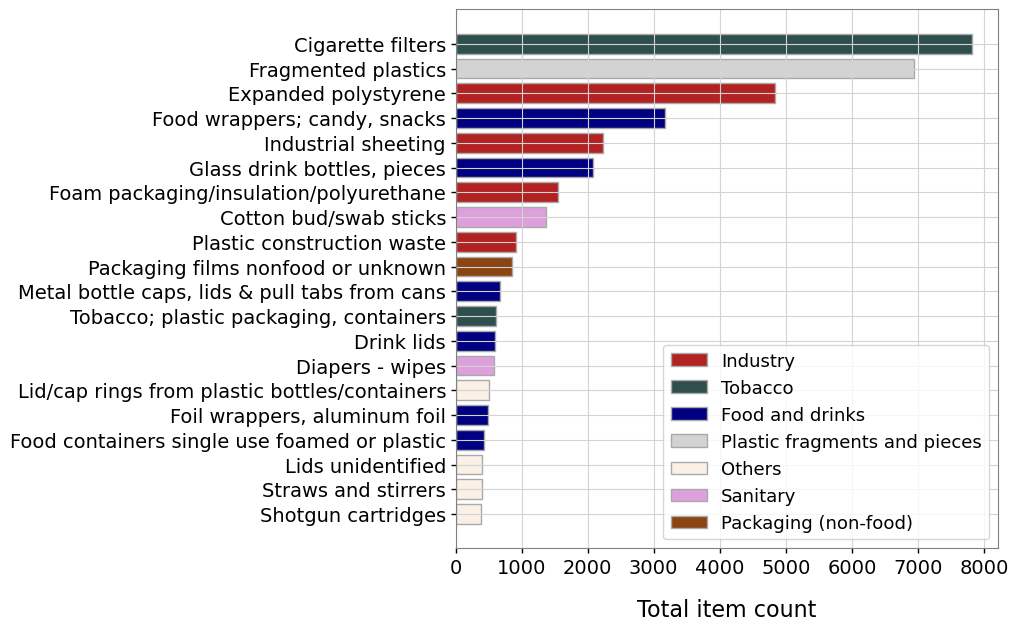

In [108]:
def check_condition(x, conditions, i):
    
    if list(set(x)&set(conditions[i])):
        data = conditions[i][0]        
    elif i == 0 and not list(set(x)&set(conditions[i])):
        data = "Others"    
    else:
        data = check_condition(x, conditions, i-1)
    return data

# define the broad categories:
tobaco = ["Tobacco", "Smoking related"]
industry = ['Industry','Construction', 'Industrial', 'Manufacturing']
sanitary = ["Sanitary", "Personal hygiene", "Water treatment"]
packaging = ['Packaging (non-food)','Packaging films nonfood or unknown', 'Paper packaging']
food = ['Food and drinks','Foil wrappers, aluminum foil', 'Food and drinks', 'Food and drink']
fragments = ['Plastic fragments and pieces',
             'Plastic fragments angular <5mm',
             'Styrofoam < 5mm', 
             'Plastic fragments rounded <5mm',
             'Foamed  plastic <5mm',
             'Fragmented plastics',
            ]

conditions = [tobaco, industry, sanitary, packaging, food, fragments]


dT20 = df.groupby("code", as_index=False).quantity.sum().sort_values("quantity", ascending=False)
dT20["description"] = dT20.code.map(lambda x: code_d_map[x])
dT20.set_index("code", drop=True, inplace=True)
dT20 = dT20.iloc[:20,:]
    
for each_code in dT20.index:
    srcs = dfCodes.loc[each_code][["source", "source_two", "source_three", "description"]]
    a = check_condition(srcs.values, conditions, len(conditions)-1)
    dT20.loc[each_code, "Type"] = a

fig, ax = plt.subplots(figsize=(7,7))
colors = {'Industry': 'firebrick', 'Tobacco': 'darkslategrey', 'Food and drinks': 'navy', 'Plastic fragments and pieces':'lightgrey',
         'Others':'linen','Sanitary':'plum','Packaging (non-food)':'saddlebrown'}
# N = 3
# ind = np.arange(N)
width = 0.6

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

ax.barh(dT20.description, dT20.quantity, color=[colors[i] for i in dT20.Type], edgecolor='darkgrey')
ax.invert_yaxis()  
ax.set_ylabel('')
xticks = [0,1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks])

ax.set_xlabel('Total item count', fontsize=16, labelpad =15)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=14, width=1)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')
ax.set_facecolor('white')

plt.legend(handles, labels, fontsize=13,facecolor='white', loc="lower right")
for ha in ax.legend_.legendHandles:
    ha.set_edgecolor("darkgrey")

plt.grid(True)
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')

# plt.savefig('C:/Users/schre086/figures/land_use_ch/top_20items.png', bbox_inches='tight')

plt.show()

#### Litter items of local origin

Items that have four or more positive associations with a land use category.

In [109]:
correlated = rho_at_buffer[(rho_at_buffer.exact_p <= 0.05) & (rho_at_buffer.rho > 0)]
local = correlated.code.value_counts()
local = local[local >= 4]
local.name = "correlations"
quantity = df[df.code.isin(local.index)].groupby("code").quantity.sum()
items_of_local_origin = pd.DataFrame([local, quantity]).T
items_of_local_origin

,correlations,quantity
G30,4,3162
G904,4,279
G177,4,484


#### Ubiquitous items

Items that have three or less positive associations with a land use category and are positively associated with river or stream intersections.

In [110]:
correlated = rho_at_buffer[(rho_at_buffer.exact_p <= 0.05) & (rho_at_buffer.rho > 0)]
pos_intersects = rho_at_buffer[(rho_at_buffer.use == "intersects") & (rho_at_buffer.exact_p <= 0.05)]
correlated = correlated[correlated.code.isin(pos_intersects.code.unique())]
local = correlated.code.value_counts()
local = local[local <= 3]
local.name = "correlations"
quantity = df[df.code.isin(local.index)].groupby("code").quantity.sum()
items_of_local_origin = pd.DataFrame([local, quantity]).T
items_of_local_origin

,correlations,quantity
G98,3,581
G941,3,857
G178,3,669
G21,2,593
G23,2,405
Gfrags,2,6948
G74,2,1546
G67,1,2223
G10,1,422
G89,1,918


#### Other items

Items that have three or less positive associations with a land use category and are NOT positively associated with river or stream intersections.

In [111]:
correlated = rho_at_buffer[(rho_at_buffer.exact_p <= 0.05) & (rho_at_buffer.rho > 0)]
pos_intersects = rho_at_buffer[(rho_at_buffer.use == "intersects") & (rho_at_buffer.exact_p > 0.05)]
correlated = correlated[correlated.code.isin(pos_intersects.code.unique())]
local = correlated.code.value_counts()
local = local[local <= 3]
local.name = "correlations"
quantity = df[df.code.isin(local.index)].groupby("code").quantity.sum()
items_of_local_origin = pd.DataFrame([local, quantity]).T
items_of_local_origin

,correlations,quantity
G27,3,7825
G923,3,223
G3,2,278
G25,2,613
G24,2,509
G200,1,2077
G95,1,1369
G208,1,165
G922,1,233


In [ ]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

_ANALYSTATHAMMERDIRT_
"""

md(my_block)